# **Downloading Dataset**

In [1]:
from google.colab import drive
drive.mount('/content/drive')


ModuleNotFoundError: No module named 'google.colab'

In [ ]:
from google.colab import files
files.upload() #this will prompt you to upload the kaggle.json


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"carvalhobr","key":"774e09805e4d6e369c78cc7f086c7485"}'}

Brain Tumor Image Dataset (https://www.kaggle.com/datasets/denizkavi1/brain-tumor/code?datasetId=1454010&sortBy=voteCount)

1 = Meningioma

2 = Glioma

3 = Pituitary tumor **bold text** bold text

In [ ]:
!ls -lha kaggle.json
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d denizkavi1/brain-tumor
!unzip brain-tumor.zip

# **Pre-Processing**


In [ ]:
from glob import glob
import cv2
import os
from sklearn.cluster import KMeans
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.utils import array_to_img
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import torch
import torch.nn as nn
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler

In [1]:
 class Preprocessing:
    def __init__(self, folder):
        self.folder = folder
        self.root = "/content/drive/MyDrive"
        self.prime_path = os.path.join(self.root,f'{self.folder}prime')
        self.seg_path = os.path.join(self.root,f'{self.folder}segment')

        self.train_enhanced_folder = os.path.join(self.root,f'train_enhanced/{self.folder}')
        self.test_enhanced_folder = os.path.join(self.root,f'test_enhanced/{self.folder}')

        train_enhance_folder = os.path.join(self.root,f'train_enhanced')
        if not os.path.exists(train_enhance_folder):
            os.mkdir(train_enhance_folder)

        test_enhance_folder = os.path.join(self.root,f'test_enhanced')
        if not os.path.exists(test_enhance_folder):
            os.mkdir(test_enhance_folder)


    def gussian_noise(self, image):
        mean = 0
        stddev = 1

        noise = np.random.normal(loc=0, scale= 0.01, size=image.shape).astype(np.float32)

        # Add noise to image
        noisy_img = cv2.add(image, noise)

        return noisy_img



    def segmentation(self):

        if not os.path.exists(self.seg_path):
            os.mkdir(self.seg_path)

        files = glob(self.folder + '/*.png')
        self.len = len(files)
        print(files)
        print(len(files))
        for i, file in enumerate(files):
          image_path= os.path.join(os.getcwd(), file)
          image_seg=mpimg.imread(image_path)

          noisy_image_seg = self.gussian_noise(image = image_seg)

          pixels = noisy_image_seg.reshape(-1, 4)
          pixels_df = pd.DataFrame(pixels, columns=['R', 'G', 'B','A'])

          clf = KMeans(n_clusters=3, n_init='auto')
          clf.fit(pixels)
          pixels_seg0 = clf.cluster_centers_[clf.labels_]
          image_seg2 = pixels_seg0.reshape(noisy_image_seg.shape)
          image_seg2 = np.clip(image_seg2, 0, 1)

          img_path = os.path.join(self.seg_path,f'{i}.png')
          mpimg.imsave(arr=image_seg2, fname=img_path)

        print('segmentation done!')


    def augmentation(self):

        if not os.path.exists(self.prime_path):
            os.mkdir(self.prime_path)

        files = glob(self.seg_path + '/*.png')
        for i, file in enumerate(files):
            aug = ImageDataGenerator(channel_shift_range=0.2,width_shift_range=0.1, height_shift_range=0.1, rotation_range = 10,shear_range = 0.15,zoom_range = 0.5)

            img=mpimg.imread(file)
            arrimage= img.reshape((1, ) + img.shape)

            new_image= aug.flow(arrimage)
            image1 = next(new_image)[0]

            img_path = os.path.join(self.prime_path,f'{i}.png')

            mpimg.imsave(arr=image1, fname=img_path)

        print('augmentation done!')

    def enhancement(self):

        if not os.path.exists(self.train_enhanced_folder):
            os.mkdir(self.train_enhanced_folder)
        if not os.path.exists(self.test_enhanced_folder):
            os.mkdir(self.test_enhanced_folder)

        img_addresses=os.listdir(self.prime_path)
        for count, img_address in enumerate(img_addresses):

            new_path=os.path.join(self.prime_path,img_address)
            img_gr = cv2.imread(new_path,cv2.IMREAD_GRAYSCALE)

            new_img_gr= cv2.cvtColor(img_gr, cv2.COLOR_GRAY2RGB)
            lab = cv2.cvtColor(new_img_gr, cv2.COLOR_BGR2LAB)

            l_channel, a, b = cv2.split(lab)
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

            cl = clahe.apply(l_channel)
            limg = cv2.merge((cl,a,b))

            enhanced_img = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

            if self.len - count > 100:
                self.enhanced_path = os.path.join(self.train_enhanced_folder,img_address)
                mpimg.imsave(arr=enhanced_img, fname=self.enhanced_path)
            else:
                self.enhanced_path = os.path.join(self.test_enhanced_folder,img_address)
                mpimg.imsave(arr=enhanced_img, fname=self.enhanced_path)

        print('enhancement done!')



    def preprocessing(self):
        self.segmentation()
        self.augmentation()
        self.enhancement()


In [ ]:
p1 = Preprocessing(folder='1')
p1.preprocessing()

p2= Preprocessing(folder='2')
p2.preprocessing()

p3 = Preprocessing(folder='3')
p3.preprocessing()

['1/2486.png', '1/3035.png', '1/2601.png', '1/2430.png', '1/2870.png', '1/2706.png', '1/2356.png', '1/2685.png', '1/2652.png', '1/2487.png', '1/2852.png', '1/2469.png', '1/2999.png', '1/2896.png', '1/2468.png', '1/2483.png', '1/2304.png', '1/3013.png', '1/2770.png', '1/3059.png', '1/2512.png', '1/2676.png', '1/2990.png', '1/2696.png', '1/2958.png', '1/2415.png', '1/2651.png', '1/2666.png', '1/2682.png', '1/2640.png', '1/2313.png', '1/3053.png', '1/2482.png', '1/2599.png', '1/2538.png', '1/2644.png', '1/2582.png', '1/2968.png', '1/2860.png', '1/2808.png', '1/2627.png', '1/2997.png', '1/2488.png', '1/2377.png', '1/3007.png', '1/2323.png', '1/2612.png', '1/3025.png', '1/2393.png', '1/2673.png', '1/3039.png', '1/2864.png', '1/2584.png', '1/457.png', '1/3054.png', '1/2594.png', '1/2916.png', '1/2457.png', '1/2353.png', '1/2942.png', '1/2344.png', '1/2360.png', '1/2420.png', '1/2951.png', '1/3029.png', '1/3057.png', '1/3044.png', '1/2502.png', '1/2806.png', '1/2336.png', '1/2970.png', '1/277

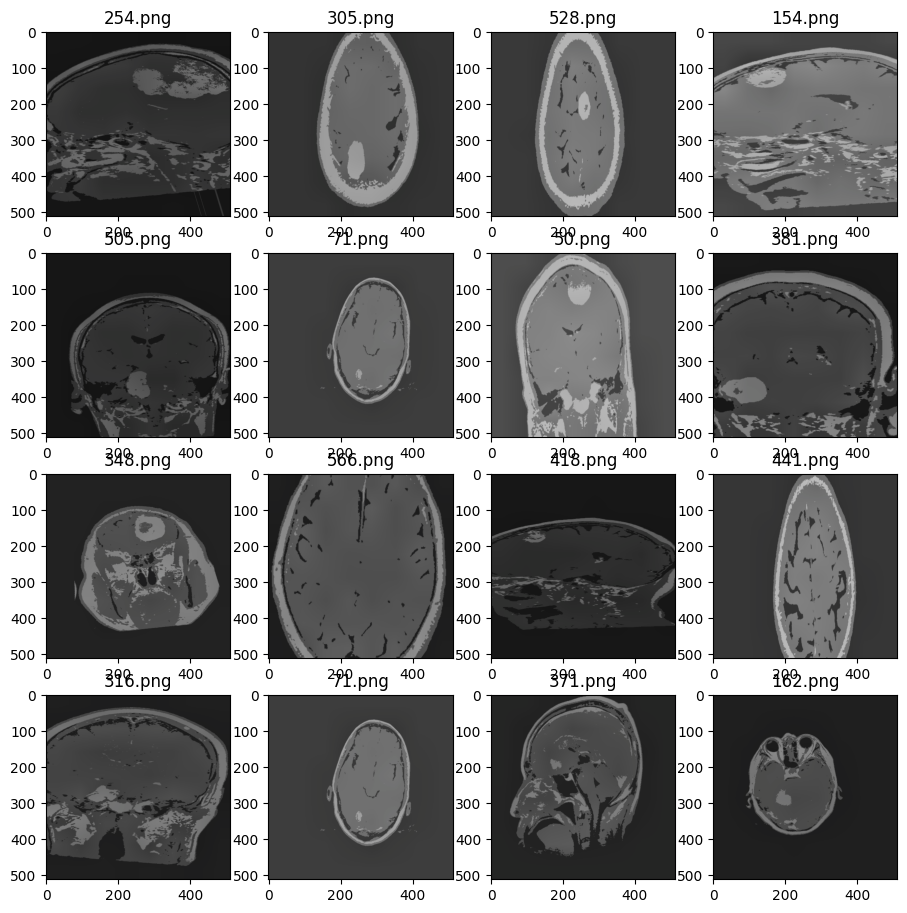

In [ ]:
def get_folder():
    plt.figure(figsize=(11,11))
    for i in range(16):
        file = random.choice(os.listdir('/content/drive/MyDrive/train_enhanced/1'))
        image_path= os.path.join('/content/drive/MyDrive/train_enhanced/1', file)
        img=mpimg.imread(image_path)
        ax=plt.subplot(4,4,i+1)
        ax.title.set_text(file)
        plt.imshow(img)
get_folder()

# **Data Loading**

In [ ]:
transform = transforms.Compose([
    transforms.Resize([256, 256]),
    transforms.ToTensor()
])

train_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/train_enhanced', transform=transform)
test_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/test_enhanced', transform=transform)
print(train_dataset)

batch_size = 2
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size , shuffle=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size , shuffle=True)
print(trainloader)

Dataset ImageFolder
    Number of datapoints: 2764
    Root location: /content/drive/MyDrive/train_enhanced
    StandardTransform
Transform: Compose(
               Resize(size=[256, 256], interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )


# **Convolutional Model**

Convolutional Block

In [ ]:
class conv_block(nn.Module):

    def __init__(self, in_c, out_c):
      super().__init__()
      self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
      self.bn1 = nn.BatchNorm2d(out_c)
      self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
      self.bn2 = nn.BatchNorm2d(out_c)
      self.relu = nn.ReLU()

    def forward(self, inputs):
      x = self.conv1(inputs)
      x = self.bn1(x)
      x = self.relu(x)

      x = self.conv2(x)
      x = self.bn2(x)
      x = self.relu(x)
      return x

Neural Block

In [ ]:
class neural_block(nn.Module):
    def __init__(self, input, out):
      super().__init__()
      self.neural = nn.Linear(input, out)
      self.relu = nn.ReLU()

    def forward(self, inputs):
      x = self.neural(inputs)
      x = self.relu(x)
      return x

Encoder block

In [ ]:
class encoder_block(nn.Module):

    def __init__(self, in_c, out_c):
      super().__init__()
      self.conv = conv_block(in_c, out_c)
      self.pool = nn.MaxPool2d((2, 2))

    def forward(self, inputs):
      x = self.conv(inputs)
      p = self.pool(x)
      return x, p

UNET Architecture

In [ ]:
class build_unet(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()

        #""" Encoder """
        self.e1 = encoder_block(3, 8)
        self.e2 = encoder_block(8, 16)
        self.e3 = encoder_block(16, 32)
        self.e4 = encoder_block(32, 64)


        #""" Bottleneck """
        self.b = conv_block(64, 128)


        self.n1 = neural_block(16*16*128, 4096)
        self.n2 = neural_block(4096, 2048)
        self.n3= nn.Sequential(
            nn.Linear(2048, num_classes))




    def forward(self, inputs):

      #""" Encoder """
      s1, p1 = self.e1(inputs)
      s2, p2 = self.e2(p1)
      s3, p3 = self.e3(p2)
      s4, p4 = self.e4(p3)


      #""" Bottleneck """
      b = self.b(p4)


      b = b.reshape(b.size(0), -1)

      n1 = self.n1(b)
      n2 = self.n2(n1)
      outputs = self.n3(n2)


      return outputs


# **Training**

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model=build_unet().to(device)
torch.cuda.is_available()

True

Hyperparameter

In [ ]:
learning_rate=0.001

num_epochs= 25

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)

total_step = len(trainloader)

Train Model

Epoch [1/25], Step [1382/1382], Loss: 0.0259
Epoch [2/25], Step [1382/1382], Loss: 0.1829
Epoch [3/25], Step [1382/1382], Loss: 0.3080
Epoch [4/25], Step [1382/1382], Loss: 0.0020
Epoch [5/25], Step [1382/1382], Loss: 0.0040
Epoch [6/25], Step [1382/1382], Loss: 0.0027
Epoch [7/25], Step [1382/1382], Loss: 0.0004
Epoch [8/25], Step [1382/1382], Loss: 0.0023
Epoch [9/25], Step [1382/1382], Loss: 0.0061
Epoch [10/25], Step [1382/1382], Loss: 0.0089
Epoch [11/25], Step [1382/1382], Loss: 0.0009
Epoch [12/25], Step [1382/1382], Loss: 0.0089
Epoch [13/25], Step [1382/1382], Loss: 0.3866
Epoch [14/25], Step [1382/1382], Loss: 0.0627
Epoch [15/25], Step [1382/1382], Loss: 0.1726
Epoch [16/25], Step [1382/1382], Loss: 0.0849
Epoch [17/25], Step [1382/1382], Loss: 0.0004
Epoch [18/25], Step [1382/1382], Loss: 0.0125
Epoch [19/25], Step [1382/1382], Loss: 0.0010
Epoch [20/25], Step [1382/1382], Loss: 0.0030
Epoch [21/25], Step [1382/1382], Loss: 0.0044
Epoch [22/25], Step [1382/1382], Loss: 0.00

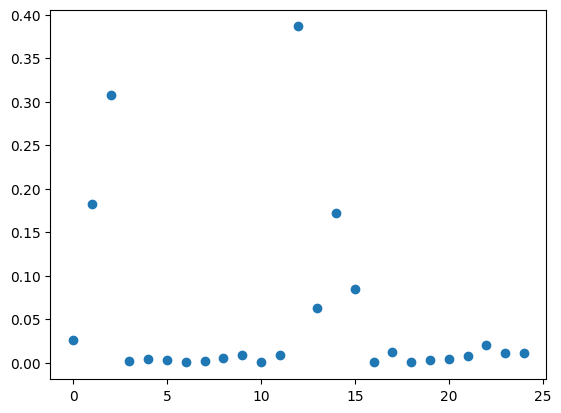

In [ ]:
loss_values=[]
epoch_values=[]

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(trainloader):

        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # if i==1000:
        #   break

    loss_values.append(loss.item())
    epoch_values.append(epoch)



    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))


plt.scatter(epoch_values, loss_values)
plt.show()

# **Test Model**

In [ ]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        del images, labels, outputs

    print('Accuracy of the network on the {} test images: {} %'.format(10000, 100 * correct / total))

Accuracy of the network on the 10000 test images: 67.33333333333333 %
